In [18]:
import sys
import json
from os import listdir
from itertools import product
import importlib
import matplotlib.pyplot as plt
import numpy as np

import input_output
importlib.reload(input_output)
import inheritance_states
importlib.reload(inheritance_states)
import transition_matrices
importlib.reload(transition_matrices)
import genotypes
importlib.reload(genotypes)
import losses
importlib.reload(losses)
import viterbi
importlib.reload(viterbi)

<module 'viterbi' from '/Users/kelley/Projects/PhasingFamilies/phase/viterbi.py'>

In [11]:
# Read in command line arguments
chrom = '10'
#ped_file = '../../DATA/platinum/platinum6.ped'
#ped_file = '../data/Ancestry Data Files/AncestryDNA.ped'
#ped_file = '../data/spark.ped.quads.ped'
#ped_file = '../data/spark.ped'
#
#data_dir = '../split_gen_ancestry'
#param_file = '../parameter_estimation/params/ancestry_params_ext.json'
#data_dir = '../split_gen_spark'
#param_file = '../parameter_estimation/params/spark_params_ext.json'
#detect_denovos = False

#data_dir = '../../DATA/spark/genotypes'
#param_file = '../params/spark_params.json'
#ped_file = '../../DATA/spark/spark.ped'
#detect_denovos = False
#detect_deletions = True
#num_loss_regions = 1

#data_dir = '../../DATA/platinum/genotypes'
#param_file = '../params/platinum_params.json'
#ped_file = '../../DATA/platinum/platinum6.ped'
#detect_denovos = False
#detect_deletions = True
#num_loss_regions = 2

#data_dir = '../../DATA/ihart.ms2/genotypes'
#param_file = '../params/ihart.ms2_params.json'
#ped_file = '../../DATA/ihart.ms2/ihart.ped'
#detect_deletions = True
#detect_duplications = False
#num_loss_regions = 2

data_dir = '../../DATA/spark.exome/genotypes'
param_file = '../params/spark.exome_quads_missing_parent_params.json'
ped_file = '../../DATA/spark.exome/spark.ped.quads.ped'
detect_deletions = False
detect_duplications = False
detect_haplotypes = False
num_loss_regions = 2

#data_dir = '../../DATA/ssc.hg38/genotypes/pilot'
#param_file = '../params/ssc.hg38_pilot_params.json'
#ped_file = '../../DATA/ssc.hg38/ssc.ped'
#detect_deletions = True
#detect_duplications = False
#num_loss_regions = 2

#data_dir = '../../DATA/mssng/genotypes'
#param_file = '../params/mssng_params.json'
#ped_file = '../../DATA/mssng/mssng.ped'
#detect_denovos = False
#detect_deletions = True
#detect_duplications = False
#num_loss_regions = 2

#data_dir = '../split_gen_ihart_23andme'
#param_file = '../parameter_estimation/23andme_params.json'

#data_dir = '../split_gen_ihart_chip'
#param_file = '../parameter_estimation/ihart_chip_params.json'

batch_size = None
batch_num = None
batch_offset = None

# set up filenames
sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
coord_file = '%s/chr.%s.gen.coordinates.npy' % (data_dir,  chrom)
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])

with open('%s/info.json' % data_dir, 'r') as f:
    assembly = json.load(f)['assembly']
    
if param_file is not None:
    with open(param_file, 'r') as f:
        params = json.load(f)
else:
    params = estimate_parameters.error_parameters(data_dir, ped_file, chrom)

In [12]:
if assembly == '37':
    max_af_cost = np.log10(15708*2/3)
    
else:
    max_af_cost = np.log10(71702*2/3)

af_boundaries = np.arange(-np.log10(0.25), max_af_cost, np.log10(2)).tolist()
af_boundaries.extend([-np.log10(1-(10.0**-x)) for x in af_boundaries[1:]])
af_boundaries = np.array(sorted(af_boundaries, reverse=True))
print('af boundaries', af_boundaries)

af boundaries [4.51544993e+00 4.21441994e+00 3.91338994e+00 3.61235995e+00
 3.31132995e+00 3.01029996e+00 2.70926996e+00 2.40823997e+00
 2.10720997e+00 1.80617997e+00 1.50514998e+00 1.20411998e+00
 9.03089987e-01 6.02059991e-01 5.79919470e-02 2.80287236e-02
 1.37882845e-02 6.83942453e-03 3.40624869e-03 1.69978488e-03
 8.49060841e-04 4.24322928e-04 2.12109641e-04 1.06041871e-04
 5.30176991e-05 2.65080405e-05 1.32538180e-05]


In [20]:
# pull families of interest
families = input_output.pull_families_missing_parent(ped_file, data_dir)

families pulled 225


In [33]:
import random

# ('AU3912', 'AU3912202', 'AU3912201')

# ()'AU1453', 'AU1453202', 'AU1453201')
#fkey = ('AU1047', 'AU1047212', 'AU1047211')
#fkey = ('AU4093', 'AU4093202', 'AU4093201')
#fkey = ('AU2757', 'AU2757202', 'AU2757201')
#fkey = ('AU0808', 'AU080801', 'AU080802')
#fkey = [k[0] for k in families_of_this_size if 'SF0010543' in k[0]][0]
#fkey = ('AU0356', 'AU035601', 'AU035602')
#fkey = ('AU1314', 'AU1314202', 'AU1314201')
#fkey = ('AU1388', 'AU1388202', 'AU1388201')
#fkey = ('AU2125', 'AU2125202', 'AU2125201')
#fkey = ('11002', '11002.mo', '11002.fa')

#fkey = ('SF0000027.SP0000034.SP0000063', 'SP0000051', 'SP0000241')
#inds = [k[1] for k in families_of_this_size if k[0]==fkey][0]

family = random.choice([x for x in families if len(x)==4])
#family = [x for x in families if x.id=='AU0001'][0]
m = len(family)
print('family', family, m)

family SF0112312.SP0112313.SP0112312 4


In [34]:
print(family.individuals)

['SP0112311', '0', 'SP0112312', 'SP0112313']


In [35]:
importlib.reload(transition_matrices)
importlib.reload(inheritance_states)

# create inheritance states
states = inheritance_states.InheritanceStates(family, 
                                              detect_deletions, detect_deletions, 
                                              detect_duplications, detect_duplications, 
                                              detect_haplotypes, num_loss_regions)

# create transition matrix
transitions = transition_matrices.TransitionMatrix(states, params)


[[1], [1], [1], [1]]
fixed [('SP0112312', 'mat'), ('SP0112312', 'pat')]
inheritance states (8, 9)
transitions (8, 4)


In [36]:
importlib.reload(losses)
import losses

# create loss function
loss = losses.LazyLoss(states, family, params, num_loss_regions, af_boundaries)

#indices = [x[6]==1 and x[7]==1 for x in loss.loss_states]
#print(np.sum(indices)/len(indices))
#loss.losses[indices, :] += 0.001

#for s, l1, l2, l3, l4 in zip(states, loss((0,)*m), loss((-1,)*m), loss((-2,)*m), loss((1, 0, 1, 1, 0))):
#    print(s, l1, l2, l3, l4)

#l = loss((1, 0, 1, 1, 0))
#for s in loss.loss_states:
#    s = np.asarray(s)
#    i = states.index(tuple(s))
#    if np.any(s[:4] == 2):
#        new_state = s.copy()
#        new_state[s==2] = 1
#        state_index = states.index(tuple(new_state))
#        if l[i] != l[state_index]:
#            print(s, new_state, l[i], l[state_index])
        #print(sorted(set(loss.perfect_match_indices[loss.loss_state_to_index[tuple(s)]])))
        #print(sorted(set(loss.perfect_match_indices[loss.loss_state_to_index[tuple(new_state)]])))
#print(loss((1, 2, 1, 0)))
#print(loss.get_parental_variants((1, 1, 1, 1, 1, 0, 1, 1, 1, 0), (1, 2, 1, 0, 1)))
#print(loss.get_parental_variants((1, 1, 1, 1, 1, 0, 1, 1, 1, 0), (2, 1, 2, 1, 2)))

no data ['0']
SP0112311
	0/0	0/1	1/1	./.
0/0	0.0001-0.0010	4.8989-4.6610	5.6160-5.6663	3.8640-2.6535
0/1	2.6103-2.1291	0.0035-0.0193	2.9746-2.2272	2.3514-1.5199
1/1	3.6452-3.1896	3.3167-2.1173	0.0004-0.0045	3.7514-2.6961
-/0	0.0001-0.0010	4.8989-4.6610	5.6160-5.6663	3.8640-2.6535
-/1	3.6452-3.1896	3.3167-2.1173	0.0004-0.0045	3.7514-2.6961
-/-	3.3167-2.1173	4.6306-4.4279	4.8989-4.6610	0.0002-0.0034
0
	0/0	0/1	1/1	./.
0/0	0.0000-0.0000	inf-inf	inf-inf	inf-inf
0/1	0.0000-0.0000	inf-inf	inf-inf	inf-inf
1/1	0.0000-0.0000	inf-inf	inf-inf	inf-inf
-/0	0.0000-0.0000	inf-inf	inf-inf	inf-inf
-/1	0.0000-0.0000	inf-inf	inf-inf	inf-inf
-/-	0.0000-0.0000	inf-inf	inf-inf	inf-inf
SP0112312
	0/0	0/1	1/1	./.
0/0	0.0001-0.0010	4.8989-4.6610	5.6160-5.6663	3.8640-2.6535
0/1	2.6103-2.1291	0.0035-0.0193	2.9746-2.2272	2.3514-1.5199
1/1	3.6452-3.1896	3.3167-2.1173	0.0004-0.0045	3.7514-2.6961
-/0	0.0001-0.0010	4.8989-4.6610	5.6160-5.6663	3.8640-2.6535
-/1	3.6452-3.1896	3.3167-2.1173	0.0004-0.0045	3.7514-2.6961
-

In [37]:
# pull genotype data for this family
family_genotypes, family_snp_positions, mult_factor = input_output.pull_gen_data_for_individuals(data_dir, af_boundaries, assembly, chrom, family.individuals)
loss.set_cache(family_genotypes)
print('Data pulled')

1 1 1
af_boundaries [4.51544993e+00 4.21441994e+00 3.91338994e+00 3.61235995e+00
 3.31132995e+00 3.01029996e+00 2.70926996e+00 2.40823997e+00
 2.10720997e+00 1.80617997e+00 1.50514998e+00 1.20411998e+00
 9.03089987e-01 6.02059991e-01 5.79919470e-02 2.80287236e-02
 1.37882845e-02 6.83942453e-03 3.40624869e-03 1.69978488e-03
 8.49060841e-04 4.24322928e-04 2.12109641e-04 1.06041871e-04
 5.30176991e-05 2.65080405e-05 1.32538180e-05]
(3, 3502) (3502,) (3502,) (3503,)
(3, 3502) (3502,)
0
genotypes pulled (5, 6961)
cached losses (8, 103) already_calculated 0
losses (8, 103) 0.006592 MB
Data pulled


In [38]:
importlib.reload(viterbi)

# forward sweep
v_cost = viterbi.viterbi_forward_sweep(family_genotypes, family_snp_positions, mult_factor, states, transitions, loss)




v_cost (8, 6961) 0.445504 MB
transition_matrix (8, 4)
Forward sweep complete 0.604525089263916 sec


In [39]:
importlib.reload(viterbi)

# backward sweep
final_states = viterbi.viterbi_backward_sweep(v_cost, states, transitions)


final_states (13, 6961) 0.090493 MB
Num solutions (1,) 3914.6944583072855 (array([1, 1, 1, 1, 0, 0, 0, 0, 0], dtype=int8),)
Num forks 1458
Backward sweep complete 0.9457268714904785 sec


In [40]:
importlib.reload(viterbi)

v_path_new, v_cost_new = viterbi.viterbi_forward_sweep_low_memory(family_genotypes, family_snp_positions, mult_factor, states, transitions, loss)


v_path (8, 6961) 0.055688 MB
Forward sweep complete 1.4556500911712646 sec


In [41]:
importlib.reload(viterbi)

# backward sweep
final_states_new = viterbi.viterbi_backward_sweep_low_memory(v_path_new, v_cost_new, states, transitions)


final_states (13, 6961) 0.090493 MB
Num solutions (1,) 3916.8721349581747 (array([1, 1, 1, 1, 0, 0, 0, 0, 0], dtype=int8),)
Backward sweep complete 0.015776634216308594 sec


In [42]:
print(np.sum(np.all(final_states==final_states_new, axis=0)))
print(np.sum(~np.all(final_states==final_states_new, axis=0)))


5198
1763


In [43]:
print(final_states[:, -1])
print(final_states_new[:, -1])

[1 1 1 1 0 1 2 3 0 2 0 2 0]
[1 1 1 1 0 1 2 3 0 2 0 2 0]


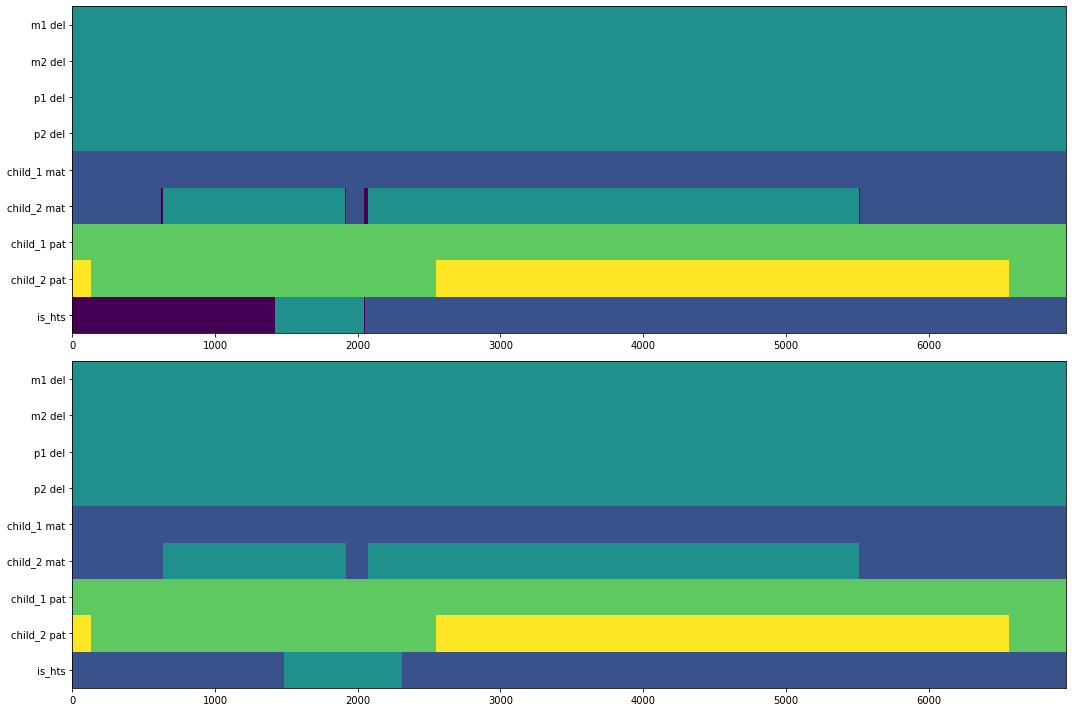

In [44]:
final_states_greyed = final_states.copy()
final_states_greyed[:, final_states[-1, :]!=0] = -1

plt.figure(figsize=(15, 10))
ax = plt.subplot(2, 1, 1)
plt.imshow(final_states[[0, 1, 2, 3] + \
                               np.arange(8, 4+(2*m), 2).tolist() + \
                               np.arange(9, 4+(2*m), 2).tolist() + [-1], :],
           aspect='auto', vmin=-1, vmax=3)
plt.yticks(np.arange(final_states.shape[0]-4), 
           ['m1 del', 'm2 del', 'p1 del', 'p2 del'] + ['child_%d mat' % i for i in range(1, m-1)] + ['child_%d pat' % i for i in range(1, m-1)] + ['is_hts'])

final_states_greyed_new = final_states_new.copy()
final_states_greyed_new[:, final_states_new[-1, :]!=0] = -1

ax = plt.subplot(2, 1, 2)
plt.imshow(final_states_new[[0, 1, 2, 3] + \
                               np.arange(8, 4+(2*m), 2).tolist() + \
                               np.arange(9, 4+(2*m), 2).tolist() + [-1], :],
           aspect='auto', vmin=-1, vmax=3)
plt.yticks(np.arange(final_states.shape[0]-4), 
           ['m1 del', 'm2 del', 'p1 del', 'p2 del'] + ['child_%d mat' % i for i in range(1, m-1)] + ['child_%d pat' % i for i in range(1, m-1)] + ['is_hts'])

#plt.subplot(2, 1, 2, sharex=ax)
#plt.fill_between(np.arange(family_snp_positions.shape[0]), 0, (family_snp_positions[:, 0]>=0) & (family_snp_positions[:, 1]<=20500000), alpha=0.5)
#plt.fill_between(np.arange(family_snp_positions.shape[0]), 0, (family_snp_positions[:, 0]>=9600000) & (family_snp_positions[:, 1]<=16300000))
#plt.fill_between(np.arange(family_snp_positions.shape[0]), 0, (family_snp_positions[:, 1]<=9600000) | (family_snp_positions[:, 0]>=48200000))

#plt.xticks(xticks, xlabels, rotation=90)

#plt.subplot(3, 1, 3)
#plt.plot(np.log2(family_snp_positions[:, 1]-family_snp_positions[:, 0]), marker='.', linestyle='')
#plt.plot(c[1:]-c[:-1], marker='.', linestyle='')
#plt.plot(num_non_mend, marker='.', linestyle='')
#plt.plot(np.convolve(num_non_mend, np.ones((100,)), mode='same'))
#plt.plot(np.convolve(num_missing, np.ones((100,)), mode='same'))
#plt.scatter(family_snp_positions[:, 0], final_states[-1, :], marker='.')
#plt.xticks(family_snp_positions[xticks, 0], xlabels, rotation=90)
#for i in np.where(family_snp_positions[:, 1]-family_snp_positions[:, 0] > 10000)[0]:
#    plt.plot([family_snp_positions[i, 0], family_snp_positions[i, 1]], [final_states[-1, i], final_states[-1, i]], color='grey')
#    #print(family_snp_positions[i, :])

#start_pos, end_pos = 3292640, 3293187
#plt.xlim(np.searchsorted(family_snp_positions[:, 0], [start_pos-1000000, end_pos+1000000]))
plt.tight_layout()
plt.show()

In [26]:
sample_id_to_sex = input_output.pull_sex(ped_file)

print([sample_id_to_sex[x] for x in family.individuals[2:]])


['1', '1']


In [27]:
is_hts = final_states[-1, :]==1

has_m1_deletion = final_states[0, :]==0
has_m2_deletion = final_states[1, :]==0
has_p1_deletion = final_states[2, :]==0
has_p2_deletion = final_states[3, :]==0
has_m1_duplication = final_states[0, :]==2
has_m2_duplication = final_states[1, :]==2
has_p1_duplication = final_states[2, :]==2
has_p2_duplication = final_states[3, :]==2

has_haplotype = np.any(final_states[:4, :]>2, axis=0)
has_full_haplotype = (final_states[1, :]==3) & (final_states[2, :]==4) & (final_states[3, :]==5)
has_cross_haplotype = ~has_full_haplotype & ((final_states[2, :]==3) | (final_states[2, :]==4) | (final_states[3, :]==3) | (final_states[3, :]==4))
has_maternal_haplotype = ~has_full_haplotype & ~has_cross_haplotype & (final_states[1, :]==3)
has_paternal_haplotype = ~has_full_haplotype & ~has_cross_haplotype & (final_states[3, :]==5)
has_both_haplotype = ~has_full_haplotype & has_maternal_haplotype & has_paternal_haplotype
has_maternal_haplotype = has_maternal_haplotype & ~has_both_haplotype
has_paternal_haplotype = has_paternal_haplotype & ~has_both_haplotype

m1_is_inherited = np.sum(final_states[np.arange(8, 4+(2*m), 2).tolist() + np.arange(9, 4+(2*m), 2).tolist(), :]==0, axis=0)>0
m2_is_inherited = np.sum(final_states[np.arange(8, 4+(2*m), 2).tolist() + np.arange(9, 4+(2*m), 2).tolist(), :]==1, axis=0)>0
p1_is_inherited = np.sum(final_states[np.arange(8, 4+(2*m), 2).tolist() + np.arange(9, 4+(2*m), 2).tolist(), :]==2, axis=0)>0
p2_is_inherited = np.sum(final_states[np.arange(8, 4+(2*m), 2).tolist() + np.arange(9, 4+(2*m), 2).tolist(), :]==3, axis=0)>0

print('hard to sequence', np.sum(mult_factor * is_hts)/np.sum(mult_factor))     
print('has haplotype', np.sum(mult_factor * has_haplotype)/np.sum(mult_factor))     
print('has mat haplotype', np.sum(mult_factor * has_maternal_haplotype)/np.sum(mult_factor))     
print('has pat haplotype', np.sum(mult_factor * has_paternal_haplotype)/np.sum(mult_factor))     
print('has both haplotype', np.sum(mult_factor * has_both_haplotype)/np.sum(mult_factor))     
print('has cross haplotype', np.sum(mult_factor * has_cross_haplotype)/np.sum(mult_factor))     
print('has full haplotype', np.sum(mult_factor * has_full_haplotype)/np.sum(mult_factor))     

print('m1 deletion', np.sum(mult_factor * (has_m1_deletion & ~is_hts))/np.sum(mult_factor))
print('m2 deletion', np.sum(mult_factor * (has_m2_deletion & ~is_hts))/np.sum(mult_factor))
print('p1 deletion', np.sum(mult_factor * (has_p1_deletion & ~is_hts))/np.sum(mult_factor))
print('p2 deletion', np.sum(mult_factor * (has_p2_deletion & ~is_hts))/np.sum(mult_factor))

print('m1 duplication', np.sum(mult_factor * (has_m1_duplication & ~is_hts))/np.sum(mult_factor))
print('m2 duplication', np.sum(mult_factor * (has_m2_duplication & ~is_hts))/np.sum(mult_factor))
print('p1 duplication', np.sum(mult_factor * (has_p1_duplication & ~is_hts))/np.sum(mult_factor))
print('p2 duplication', np.sum(mult_factor * (has_p2_duplication & ~is_hts))/np.sum(mult_factor))

has_denovo = np.any(final_states[4+2*len(family):-1, :]==1, axis=0)
print('has de novo', has_denovo, np.sum(has_denovo))

## maternal UPD
#print('maternal UPD', np.sum(mult_factor * ((has_upd[0, :] | has_upd[1, :]) & ~is_hts)))
#print('paternal UPD', np.sum(mult_factor * ((has_upd[2, :] | has_upd[3, :]) & ~is_hts)))#
#
#for i in range(m-2):
#    print('child%d mat upd' % (i+1), np.sum(mult_factor * (has_upd[4+2*i, :] & ~is_hts)))
#    print('child%d pat upd' % (i+1), np.sum(mult_factor * (has_upd[5+2*i, :] & ~is_hts)))


hard to sequence 0.1280395558306051
has haplotype 0.764863096936796
has mat haplotype 0.06626755979388385
has pat haplotype 0.07410657885032851
has both haplotype 0.025100765400191752
has cross haplotype 0.5676216800325784
has full haplotype 0.031766512859813446
m1 deletion 0.00010068523678666593
m2 deletion 0.0004832250058519286
p1 deletion 7.2788371817112e-05
p2 deletion 0.0
m1 duplication 0.0
m2 duplication 0.0
p1 duplication 0.0
p2 duplication 0.0
has de novo [False False False ... False False False] 0


In [64]:
a = np.array([0, 5, 2, 1, 6])
print(a)

indices = np.arange(5)
random.shuffle(indices)
reverse_indices[indices] = np.arange(5)
print(indices, reverse_indices)

print(a[indices])
print(a[indices][reverse_indices])


[0 5 2 1 6]
[3 0 4 1 2] [1 3 4 0 2]
[1 0 6 5 2]
[0 5 2 1 6]


In [28]:
event = has_denovo
#event = has_upd[6, :]
del_start = np.where(~event[:-1] & event[1:])[0]+1
del_end = np.where(event[:-1] & ~event[1:])[0]+1

print(len(del_start), len(del_end))
print(del_start, del_end)

# remove events in hard to sequence regions
event_is_hts = np.ones((del_start.shape[0],), dtype=bool)
for i, (s, e) in enumerate(zip(del_start, del_end)):
    event_is_hts[i] = np.all(is_hts[s:e])
print('hard to seq', np.sum(event_is_hts))

# remove events that aren't inherited
#event_is_inherited = np.ones((del_start.shape[0],), dtype=bool)
#for i, (s, e) in enumerate(zip(del_start, del_end)):
#    event_is_inherited[i] = np.any(event_inherited[s:e])
#print('not inherited', np.sum(~event_is_inherited))
    
#del_start = np.array(del_start)[~event_is_hts & event_is_inherited]
#del_end = np.array(del_end)[~event_is_hts & event_is_inherited]
#print(len(del_start), len(del_end))

print(del_start, del_end)

0 0
[] []
hard to seq 0
[] []


In [29]:
dstart, dend = random.choice(list(zip(del_start, del_end)))
start, end = max(0, dstart-100), min(dend+100, family_genotypes.shape[1])

print(final_states[:, start])
#print(dstart, dend)
#print(family_snp_positions[dstart, :], family_snp_positions[dend, :])
#start, end = 168156000, 168172000
#start, end = 71706745, 71715561
#start, end = 225044, 225185

#start, end = 3711060, 3711393
#start, end = np.where(family_snp_positions[:, 0]>=start)[0][0], np.where(family_snp_positions[:, 0]<=end)[0][-1]
#start, end = max(0, start-100), min(end+100, family_genotypes.shape[1])

state_indices_of_interest = []

plt.figure(figsize=(15, 10))
ax = plt.subplot(4, 1, 1)
plt.plot(mult_factor[start:end])
homref = np.all(family_genotypes[:-1, start:end]==0, axis=0)
plt.plot(np.where(~homref)[0], loss.alt_costs[family_genotypes[-1, start:end]][~homref])
plt.plot(np.where(homref)[0], loss.alt_costs[family_genotypes[-1, start:end]][homref])
plt.ylim([0, 10])

plt.subplot(4, 1, 2, sharex=ax)
plt.imshow(family_genotypes[:-1, start:end], aspect='auto', vmin=-3, vmax=2)
plt.yticks(np.arange(m), ['mom', 'dad'] + ['child %d' % i for i in range(1, m-1)])

plt.subplot(4, 1, 3, sharex=ax)
plt.imshow(final_states[[0, 1, 2, 3] + \
                               [4, 5] + np.arange(8, 4+(2*m), 2).tolist() + \
                               [6, 7] + np.arange(9, 4+(2*m), 2).tolist() + [-1], start:end],
           aspect='auto', vmin=-1, vmax=3)
plt.yticks(np.arange(final_states.shape[0]-8), 
           ['m1 del', 'm2 del', 'p1 del', 'p2 del', 'm1', 'm2'] + ['child_%d mat' % i for i in range(1, m-1)] + ['p1', 'p2'] + ['child_%d pat' % i for i in range(1, m-1)] + ['is_hts'])

plt.subplot(4, 1, 4, sharex=ax)
plt.imshow(final_states[np.arange(16, 20).tolist(), start:end],
           aspect='auto', vmin=-1, vmax=3)
plt.yticks(np.arange(4), 
           ['child1 mat', 'child1 pat', 'child2 mat', 'child2 pat'])

#plt.subplot(4, 1, 4, sharex=ax)
#plt.plot([loss(tuple(family_genotypes[:, j]))[states.index(tuple(np.clip(final_states[:, j], 0, None)))] for j in range(start, end)], alpha=0.5)

#plt.subplot(5, 1, 5, sharex=ax)
#plt.plot([loss(tuple(family_genotypes[:, j]))[states.index(tuple(np.clip(final_states[:, j], 0, None)))] for j in range(start, end)], alpha=0.5)
#plt.plot([loss(tuple(family_genotypes[:, j]))[states.index(tuple(np.hstack((np.clip(final_states[:2*m, j], 0, None), [0,]*(2*(m-2)), [np.clip(final_states[-1, j], 0, None)]))))] for j in range(start, end)], alpha=0.5)
#plt.plot([loss(tuple(family_genotypes[:, j]))[states.index(tuple(np.hstack(([1,]*4, np.clip(final_states[4:, j], 0, None)))))] for j in range(start, end)], alpha=0.5)
#plt.plot([loss(tuple(family_genotypes[:, j]))[states.index((1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0))] for j in range(start, end)], alpha=0.5)
#plt.plot(np.cumsum([loss(tuple(family_genotypes[:, j]))[states.index((1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0))] for j in range(start, end)]), alpha=0.5)
#plt.plot(np.cumsum([loss(tuple(family_genotypes[:, j]))[states.index((1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0))] for j in range(start, end)]), alpha=0.5)
#plt.plot([loss(tuple(family_genotypes[:, j]))[states.index((1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0))] for j in range(start, end+1)], alpha=0.5)
#plt.plot([loss(tuple(family_genotypes[:, j]))[states.index((0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0))] for j in range(start, end+1)], alpha=0.5)



plt.tight_layout()
plt.show()

IndexError: Cannot choose from an empty sequence

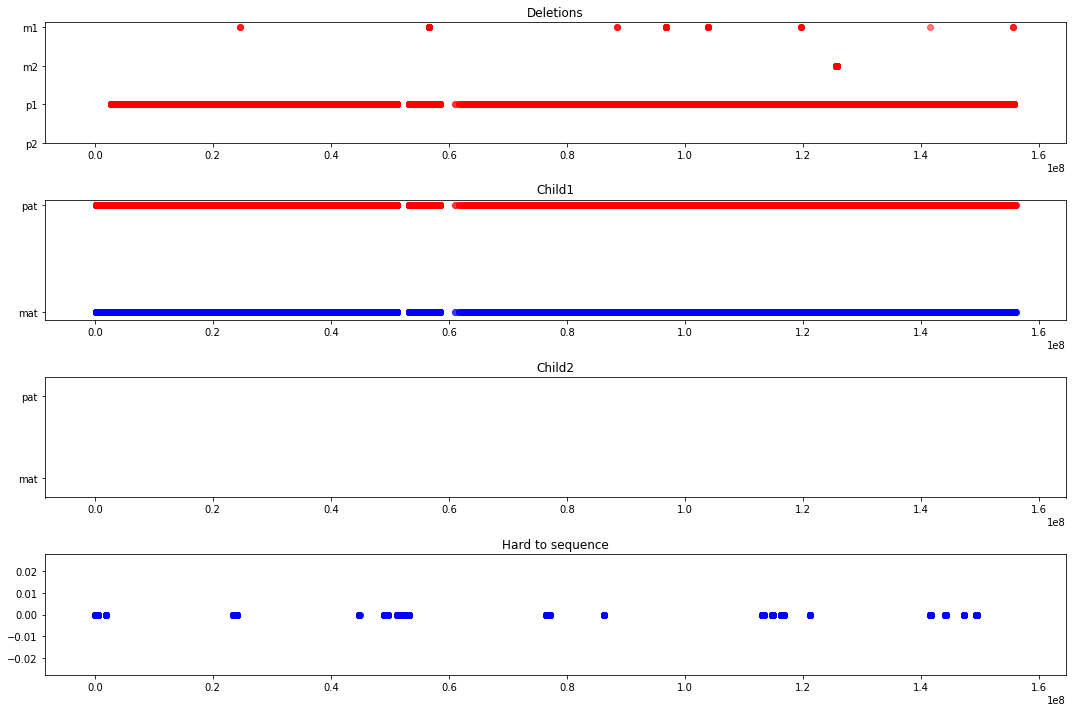

In [21]:
plt.figure(figsize=(15, 10))

ax = plt.subplot(m, 1, 1)

for i in range(4):
    #plt.scatter(family_snp_positions[final_states_greyed[i, :] == -1, 0], np.repeat(3-i, np.sum(final_states_greyed[i, :] == -1)), color='blue', alpha=0.5)
    plt.scatter(family_snp_positions[final_states_greyed[i, :] == 0, 0], np.repeat(3-i, np.sum(final_states_greyed[i, :] == 0)), color='red', alpha=0.5)
plt.title('Deletions')
plt.yticks(range(3, -1, -1), ['m1', 'm2', 'p1', 'p2'])

for i in range(0, m-2):
    plt.subplot(m, 1, i+2, sharex=ax)
    indices = (final_states_greyed[4+(2*i), :] == 0) & (final_states_greyed[-1, :] == 0)
    plt.scatter(family_snp_positions[indices, 0], np.repeat(0, np.sum(indices)), color='blue', alpha=0.5)
    indices = (final_states_greyed[4+(2*i), :] == 1) & (final_states_greyed[-1, :] == 0)
    plt.scatter(family_snp_positions[indices, 0], np.repeat(0, np.sum(indices)), color='red', alpha=0.5)

    indices = (final_states_greyed[5+(2*i), :] == 0) & (final_states_greyed[-1, :] == 0)
    plt.scatter(family_snp_positions[indices, 0], np.repeat(1, np.sum(indices)), color='blue', alpha=0.5)
    indices = (final_states_greyed[5+(2*i), :] == 1) & (final_states_greyed[-1, :] == 0)
    plt.scatter(family_snp_positions[indices, 0], np.repeat(1, np.sum(indices)), color='red', alpha=0.5)

    plt.title('Child%d' % (i+1))
    plt.yticks(range(0, 2), ['mat', 'pat'])

plt.subplot(m, 1, m, sharex=ax)
plt.scatter(family_snp_positions[final_states_greyed[-1, :] == -1, 0], np.repeat(0, np.sum(final_states_greyed[-1, :] == -1)), color='blue', alpha=0.5)
plt.scatter(family_snp_positions[final_states_greyed[-1, :] == 1, 0], np.repeat(0, np.sum(final_states_greyed[-1, :] == 1)), color='red', alpha=0.5)
plt.title('Hard to sequence')

plt.tight_layout()
plt.show()



In [ ]:
print(family_snp_positions[start, :], family_snp_positions[end, :])

In [ ]:
import numpy as np
def estimate_parental_variants(final_states, family_genotypes):
    m, n = family_genotypes.shape
    parental_variants, cost, blame = -np.ones((4, n), dtype=np.int8), -np.ones((n,), dtype=int), -np.ones((m, n), dtype=float)
    has_missing = 0
    for i in range(n):
        state, gen = final_states[:, i], tuple(family_genotypes[:, i])
        
        missing_indices = [i for i, x in enumerate(state) if x==-1]
        
        if len(missing_indices) == 0:
            pv, v, b = loss.get_parental_variants(tuple(state), gen)
            parental_variants[:, i] = pv
            cost[i] = v
            blame[:, i] = b
        else:
            has_missing += 1
            all_possible_states = np.tile(state, (pow(2, len(missing_indices)), 1))
            all_possible_states[:, missing_indices] = list(product(*[[0, 1]]*len(missing_indices)))

            min_v = None
            all_pvs, all_bs = [], []
            for s in all_possible_states:
                pv, v, b = loss.get_parental_variants(tuple(s), gen)
                if min_v is None or v < min_v:
                    min_v = v
                    all_pvs, all_bs = [pv], [b]
                elif v == min_v:
                    all_pvs.append(pv)
                    all_bs.append(b)

            all_pvs, all_bs = np.asarray(all_pvs), np.asarray(all_bs)
            parental_variants[np.all(all_pvs==-2, axis=0), i] = -2
            parental_variants[np.all(all_pvs==0, axis=0), i] = 0
            parental_variants[np.all(all_pvs==1, axis=0), i] = 1
            cost[i] = min_v
            
            all_bs = np.sum(all_bs, axis=0)
            if min_v == 0:
                blame[:, i] = 0
            else:
                blame[:, i] = min_v*all_bs/np.sum(all_bs)
            
        if i%10000==0:
            print(i, has_missing)
    return parental_variants, cost, blame

parental_variants, cost, blame = estimate_parental_variants(states, family_genotypes)       

In [ ]:
import time
import numpy as np
from itertools import product

def mask_states(family_genotypes, mult_factor, final_states, inheritance_states, loss, error_rate=0.001, smooth=5000):

	masked_final_states = np.copy(final_states)
	# Now, do masking
	prev_time = time.time()
	m, n = family_genotypes.shape
	p, state_len = inheritance_states.p, inheritance_states.state_len

	fit = -np.ones((n,), dtype=int)
	prev_state = None
	prev_state_indices = None
	for j in range(n): 
		pos_gen = tuple(family_genotypes[:, j])
		current_state = tuple(final_states[:, j])

		if current_state != prev_state:
			prev_state = current_state
			num_unknowns = len([x for x in current_state if x == -1])
			if num_unknowns>0:
				prev_state_indices = []
				for poss_itr in [iter(x) for x in product(*([[0, 1]]*num_unknowns))]:
					poss_state = tuple([x if x != -1 else next(poss_itr) for x in current_state])
					prev_state_indices.append(inheritance_states.index(poss_state))
			else:
				prev_state_indices = [inheritance_states.index(tuple(final_states[:, j]))]

		fit[j] = mult_factor[j]*(np.min(loss(pos_gen)[prev_state_indices])==1)
        
	print(np.unique(fit, return_counts=True))


	c = np.convolve(fit/m, np.ones(smooth,), mode='same')
	masked = (c>(error_rate*smooth)).astype(np.int8)
	print('Percent masked', 100*np.sum(masked)/n)

	# if a parental chromosome isn't inherited, then we don't know if it has a deletion
	maternal_indices = range(4, state_len, 2)
	paternal_indices = range(5, state_len, 2)

	m1_ninh = np.all(final_states[maternal_indices, :]!=0, axis=0)
	m2_ninh = np.all(final_states[maternal_indices, :]!=1, axis=0)
	p1_ninh = np.all(final_states[paternal_indices, :]!=0, axis=0)
	p2_ninh = np.all(final_states[paternal_indices, :]!=1, axis=0)

	masked_final_states[0, m1_ninh] = -1
	masked_final_states[1, m2_ninh] = -1
	masked_final_states[2, p1_ninh] = -1
	masked_final_states[3, p2_ninh] = -1
	masked_final_states = np.append(masked_final_states, masked[np.newaxis, :], axis=0)
	print('Percent never inherited', 100*np.sum(m1_ninh)/n, 100*np.sum(m2_ninh)/n, 100*np.sum(p1_ninh)/n, 100*np.sum(p2_ninh)/n)

	print('Masking complete', time.time()-prev_time, 'sec') 
	return masked_final_states, c

In [ ]:
# mask messy areas
masked_final_states, f = mask_states(family_genotypes, mult_factor, final_states, inheritance_states, loss, error_rate=0.01)
#masked_final_states[:, masked_final_states[-1, :]==1] = -1

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(f/1000)
plt.plot(overall)
plt.show()

In [ ]:
smooth=5000
c = np.convolve(np.sum(parental_variants==-2, axis=0), np.ones(smooth,), mode='same')/(smooth*m)
d = np.convolve(np.sum(parental_variants==-1, axis=0), np.ones(smooth,), mode='same')/(smooth*m)

plt.figure(figsize=(15, 5))
plt.plot(a, label='deletion')
plt.plot(b, label='unknown')
plt.plot(c, label='deletion')
plt.plot(d, label='unknown')
#plt.plot(overall)
#plt.ylim([0, 0.1])
plt.axhline(0.01)
plt.legend()
plt.show()

In [ ]:
print(np.sum(parental_variants==-1)/(4*parental_variants.shape[1]))

In [ ]:
print(np.sum(blame==0)/(blame.shape[0]*blame.shape[1]))
print(np.sum(parental_variants==0)/(parental_variants.shape[0]*parental_variants.shape[1]))


In [ ]:
pos_lens = family_snp_positions[:, 1]-family_snp_positions[:, 0]
print(pos_lens.shape)
print(np.sum(parental_variants!=0))
print(np.sum(mult_factor*np.sum(parental_variants!=0, axis=0)))
print(np.sum(mult_factor[np.any(parental_variants!=0, axis=0)]))

In [ ]:
import scipy.sparse as sparse

chrom_length = chrom_lengths[chrom]
nonzeros = np.sum(mult_factor*np.sum(parental_variants!=0, axis=0))
data = np.zeros((nonzeros,), dtype=np.int8)
row_ind = np.zeros((nonzeros,), dtype=int)
col_ind = np.zeros((nonzeros,), dtype=int)

data_index = 0
for i, j in zip(*np.nonzero(parental_variants)):
    pos_start, pos_end = family_snp_positions[j, :]
    pos_length = pos_end - pos_start
    
    data[data_index:(data_index+pos_length)] = parental_variants[i, j]
    row_ind[data_index:(data_index+pos_length)] = i
    col_ind[data_index:(data_index+pos_length)] = range(pos_start, pos_end)
    data_index += pos_length

parental_variants_csc = sparse.csc_matrix((data, (row_ind, col_ind)), shape=(4, chrom_length))

In [ ]:
print(np.nonzero(parental_variants)[0].shape)
print(data[:5])
print(parental_variants_csc.nnz)

In [ ]:
import random
j = random.choice(np.where(mult_factor*np.any(parental_variants!=0, axis=0)>1)[0])
print(j, family_snp_positions[j, :])
print(parental_variants[:, j])
print(parental_variants_csc[:, family_snp_positions[j, 0]:family_snp_positions[j, 1]])

In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow((parental_variants==-1)[:1000], aspect='auto')
plt.show()

In [ ]:
smooth=5000
mo = np.convolve(blame[0, :], np.ones(smooth,), mode='same')/smooth
d = np.convolve(blame[1, :], np.ones(smooth,), mode='same')/smooth
c1 = np.convolve(blame[2, :], np.ones(smooth,), mode='same')/smooth
c2 = np.convolve(blame[3, :], np.ones(smooth,), mode='same')/smooth
c3 = np.convolve(blame[4, :], np.ones(smooth,), mode='same')/smooth
overall = np.convolve(np.sum(blame, axis=0), np.ones(smooth,), mode='same')/smooth

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))

ax1 = plt.subplot(2, 1, 1)
plt.plot(mo, label='mom')
plt.plot(d, label='dad')
plt.plot(c1, label='child1')
plt.plot(c2, label='child2')
plt.plot(c3, label='child3')
plt.plot(overall, label='overall', color='black')
plt.axhline(0.01, color='black')
plt.legend()
plt.ylim([0, 0.1])

all_convolve = np.vstack((mo, d, c1, c2, c3))

plt.subplot(2, 1, 2, sharex=ax1)
plt.imshow(np.vstack((masked_final_states[-1, :], np.sum(all_convolve>0.01, axis=0)>1)), aspect='auto')

plt.show()

In [ ]:

plt.figure(figsize=(15, 10))

ax1 = plt.subplot(3, 1, 1)
plt.plot(mo, label='mom')
plt.plot(d, label='dad')
plt.plot(c1, label='child1')
plt.plot(c2, label='child2')
plt.plot(c3, label='child3')
#plt.plot(b)
plt.legend()

plt.subplot(3, 1, 2, sharex=ax1)
plt.imshow(final_states, aspect='auto')

plt.subplot(3, 1, 3, sharex=ax1)
plt.imshow(masked_final_states, aspect='auto')

plt.show()

In [ ]:
smooth=5000
mo = np.convolve(blame[0, :], np.ones(smooth,), mode='same')/smooth
d = np.convolve(blame[1, :], np.ones(smooth,), mode='same')/smooth
c1 = np.convolve(blame[2, :], np.ones(smooth,), mode='same')/smooth
c2 = np.convolve(blame[3, :], np.ones(smooth,), mode='same')/smooth
c3 = np.convolve(blame[4, :], np.ones(smooth,), mode='same')/smooth
overall = np.convolve(np.sum(blame, axis=0), np.ones(smooth,), mode='same')/smooth

plt.figure(figsize=(15, 10))

ax1 = plt.subplot(3, 1, 1)
plt.plot(mo, label='mom')
plt.plot(d, label='dad')
plt.plot(c1, label='child1')
plt.plot(c2, label='child2')
plt.plot(c3, label='child3')
#plt.plot(b)
plt.legend()

plt.subplot(3, 1, 2, sharex=ax1)
plt.imshow(final_states, aspect='auto')

plt.subplot(3, 1, 3, sharex=ax1)
plt.imshow(masked_final_states, aspect='auto')

plt.show()

In [ ]:
m = 5
smooth = 5000

In [ ]:
# family-wise unphased mendelian
unique_gens, indices = np.unique(family_genotypes, axis=1, return_inverse=True)

parents_to_children_with_del = {
    (-1, -1): [-1],
    (-1, 0): [-1, 0],
    (-1, 1): [0, 2],
    (-1, 2): [-1, 2],
    (0, 0): [-1, 0],
    (0, 1): [0, 1, 2],
    (0, 2): [-1, 0, 1, 2],
    (1, 1): [0, 1, 2],
    (1, 2): [0, 1, 2],
    (2, 2): [-1, 2]
    
}

parents_to_children_without_del = {
    (0, 0): [0],
    (0, 1): [0, 1],
    (0, 2): [1],
    (1, 1): [0, 1, 2],
    (1, 2): [1, 2],
    (2, 2): [2]
    
}
parental_genotypes = list(product(*[[0, 1, 2]]*2))

# without del
trio_perfect_match_gens_nodel = set()
trios_could_be_mendelian = np.zeros((family_genotypes.shape[1],), dtype=int)
for pg in parental_genotypes:
    trio_perfect_match_gens_nodel.update([pg + cg for cg in product(*[parents_to_children_without_del[(min(pg), max(pg))]]*(m-2))])

for i, gen in enumerate(unique_gens.T):
    missing_indices = [i for i, x in enumerate(gen) if x==-1]
    all_possible_gens = np.tile(gen, (pow(4, len(missing_indices)), 1))
    all_possible_gens[:, missing_indices] = list(product(*[[-1, 0, 1, 2]]*len(missing_indices)))
    #print(all_possible_gens)
    
    if np.any([tuple(g) in trio_perfect_match_gens_nodel for g in all_possible_gens]):
        trios_could_be_mendelian[indices==i] = 1



In [ ]:
print(len(trio_perfect_match_gens_del), len(trio_perfect_match_gens_nodel))

In [ ]:
smooth = 500*4
smoothed_cost = np.convolve(cost>0, np.ones(smooth,), mode='same')/smooth
smoothed_md_nodel = np.convolve(1-trios_could_be_mendelian, np.ones(smooth,), mode='same')/smooth
smoothed_final = np.convolve((cost>0) - 1 + trios_could_be_mendelian, np.ones(smooth,), mode='same')/smooth

plt.figure(figsize=(15, 10))

ax1 = plt.subplot(2, 1, 1)
plt.plot(smoothed_md_nodel, label='unphased mendelian no del', alpha=0.5)
plt.plot(smoothed_cost, label='phased family mendelian', alpha=0.5)
plt.plot(smoothed_cost-smoothed_md_nodel)
plt.plot(smoothed_final)

#plt.plot(mo, label='mom')
#plt.plot(d, label='dad')
#plt.plot(c1, label='child1')
#plt.plot(c2, label='child2')
#plt.plot(c3, label='child3')
plt.axhline(0.01)
plt.legend()

to_plot = []
for smooth in [1, 50, 100, 500, 1000, 5000]:
    smooth = smooth*4
    smoothed_cost = np.convolve(cost>0, np.ones(smooth,), mode='same')/smooth
    smoothed_md_nodel = np.convolve(1-trios_could_be_mendelian, np.ones(smooth,), mode='same')/smooth
    to_plot.append(smoothed_cost-smoothed_md_nodel>0.01)


plt.subplot(2, 1, 2, sharex=ax1)
plt.imshow(np.vstack((final_states, to_plot[0], to_plot[1], to_plot[2], to_plot[3], to_plot[4], to_plot[5])), aspect='auto')

plt.show()

In [ ]:
print(np.sum(1-trios_could_be_mendelian)/2/trios_could_be_mendelian.shape)
print(np.sum(cost>0)/2/cost.shape)
print((np.sum(parental_variants[:, cost==0]==-1) + m*np.sum(cost!=0))/2/(m*cost.shape[0]))

In [ ]:
print(np.sum(smoothed_md_del > 0.01)/smoothed_md_del.shape)

plt.figure(figsize=(15, 5))
plt.hist(smoothed_md_del, bins=70)
plt.xlim([0, 0.1])
plt.show()

In [ ]:

smooth=5000
#mo = np.convolve(blame[0, :], np.ones(smooth,), mode='same')/smooth
#d = np.convolve(blame[1, :], np.ones(smooth,), mode='same')/smooth
#c1 = np.convolve(blame[2, :], np.ones(smooth,), mode='same')/smooth
#c2 = np.convolve(blame[3, :], np.ones(smooth,), mode='same')/smooth
#c3 = np.convolve(blame[4, :], np.ones(smooth,), mode='same')/smooth
#overall = np.convolve(np.sum(blame, axis=0), np.ones(smooth,), mode='same')/smooth



plt.figure(figsize=(15, 10))

ax1 = plt.subplot(2, 1, 1)
plt.plot(mo, label='mom')
plt.plot(d, label='dad')
plt.plot(c1, label='child1')
plt.plot(c2, label='child2')
plt.plot(c3, label='child3')
#plt.plot(b)
plt.legend()

plt.subplot(2, 1, 2, sharex=ax1)
plt.imshow(final_states, aspect='auto')

plt.show()

In [ ]:
print(np.sum(blame[0, :]==1), np.sum(blame[1, :]==1))
print(np.sum(blame[2, :]==1), np.sum(blame[3, :]==1), np.sum(blame[4, :]==1))

In [ ]:
print('hello')

In [ ]:
smooth=500
mo = np.convolve(blame[0, :], np.ones(smooth,), mode='same')/smooth
d = np.convolve(blame[1, :], np.ones(smooth,), mode='same')/smooth
c1 = np.convolve(blame[2, :], np.ones(smooth,), mode='same')/smooth
c2 = np.convolve(blame[3, :], np.ones(smooth,), mode='same')/smooth
c3 = np.convolve(blame[4, :], np.ones(smooth,), mode='same')/smooth


plt.figure(figsize=(15, 5))

plt.plot(mo, label='mom')
plt.plot(d, label='dad')
plt.plot(c1, label='child1')
plt.plot(c2, label='child2')
plt.plot(c3, label='child3')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow(final_states, aspect='auto')
plt.show()
print(np.sum(np.any(final_states[:, 1:] != final_states[:, :-1], axis=0)))

In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow(masked_final_states, aspect='auto')
plt.show()
print(np.sum(np.any(masked_final_states[4:, 1:] != masked_final_states[4:, :-1], axis=0)))

In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow(family_genotypes[:50000, :], aspect='auto')
plt.show()


In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow(final_states, aspect='auto')
plt.show()


In [ ]:
import numpy as np
print(np.sum((family_genotypes[2, :]==1) & (family_genotypes[[0, 1, 3], :]==0)))
print(np.sum((family_genotypes[3, :]==1) & (family_genotypes[[0, 1, 2], :]==0)))

In [ ]:
print(wgs_data.chrom_length)

In [ ]:
93326/family_genotypes.shape[1]

In [ ]:
print(np.sum((family_genotypes[2, :]==1) & np.all(family_genotypes[[0, 1, 3], :]==0, axis=0))/family_genotypes.shape[1])
print(np.sum((family_genotypes[3, :]==1) & np.all(family_genotypes[[0, 1, 2], :]==0, axis=0))/family_genotypes.shape[1])

In [ ]:
print(np.sum(np.all(family_genotypes==0, axis=0))/family_genotypes.shape[1])